函数优化
---

在方程求解的基础上，我们将研究问题优化相关的主题。通常，优化是从一组候选解中寻找和选择最优解的过程。在数学优化中，这类问题通常被定义为在给定的域中找到函数的极值。

优化是一种非常重要的数学工具，在科学与工程的很多领域中都有研究和应用。不同领域中描述优化问题的术语各不相同，被优化的数学函数可能被称为代价函数（cost function）、损失函数（loss function）、能量函数（energy function）或目标函数（object function）等。这里我们使用通用的函数，目标函数。

优化问题经常与方程求解密切相关，因为在函数的最优值处，导数或梯度（多变量时）为0。但是这种方法不一定可行

## 导入模块
---


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy import optimize

import sympy
sympy.init_printing()

## 优化问题的分类
---

我们将考虑的范围限制为单个或者多个因变量的实数函数的数学优化问题上。一般优化问题可以表示为最小化问题，即$\min_x f(x)$，存在一组$m$个等式约束条件$g(x) = 0$，以及$p$个不等式约束条件$h(x) \leq 0$，其中$x$可以是标量或向量。$f(x)$的最大化问题等价于$-f(x)$的最小化问题，因此只需考虑最小化问题即可。

根据$f(x)$、$g(x)$和$h(x)$的性质，可以对优化问题进行分类。如果$x$是标量，则是单变量或者一维问题；如果$x$是向量，则是多变量或者多维问题。如果目标函数和约束条件都是线性的，则是线性优化或者线性规划问题。如果目标函数或约束条件是非线行的，则是非线性优化或者非线性规划问题。等式约束和不等式约束需要使用不同方法处理。

和之前章节一样，非线性问题相对于线性问题更难处理。一般的非线性问题可以同时具有局部最小值和全局最小值。迭代求解器可能会收敛到局部最小值而不是全局最小值。

需要注意的一点，目标函数以及约束条件是否连续和平滑是非常重要的性质。如果函数以及它们的导数或梯度不连续，或者函数中包含了测量或其它原因引起的误差，下面讨论的很多方法可能不适用。

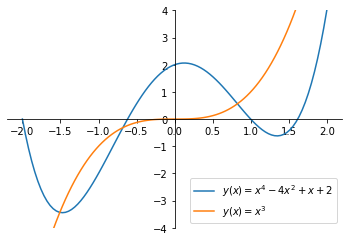

In [2]:
x = np.linspace(-2, 2, 100)
y1 = lambda x: x**4 - 4 * x**2 + x + 2
y2 = lambda x: x**3

fig, ax = plt.subplots()
ax.plot(x, y1(x), label=r"$y(x)=x^4-4x^2+x+2$")
ax.plot(x, y2(x), label=r"$y(x)=x^3$")

ax.set_ylim(-4, 4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))

ax.legend(loc='lower right')

寻找函数$f(x)$的候选最优解等同于求解方程$f'(x)=0$。方程$f'(x)=0$的解也被称为驻点（stationary point），可能对应$f(x)$的最大值或者最小值，也可能是鞍点（saddle point）。

Text(0.5, 0.92, '$f = x^4 - 4 y^2$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
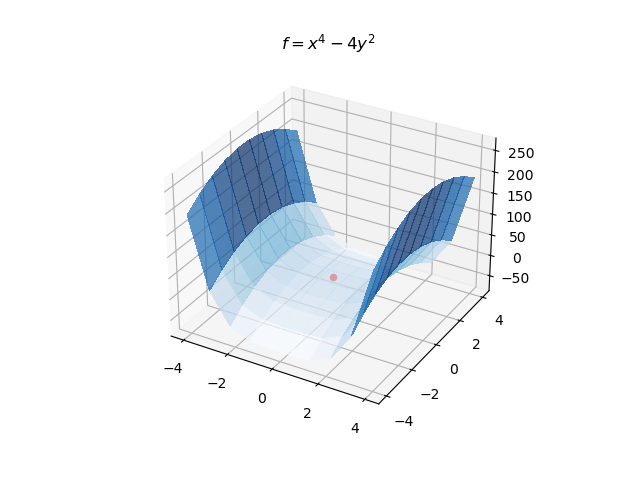

In [3]:
%matplotlib widget

x = y = np.linspace(-4, 4, 10)
X, Y = np.meshgrid(x, y)
Z = X**4 - 4 * Y**2
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.scatter3D(0, 0, 0, marker = 'o', color = 'r')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap=mpl.cm.Blues, alpha = 0.7)
ax.set_title(r'$f = x^4 - 4 y^2$')

对于无约束条件的目标函数，高阶导数或者[Hessian矩阵](https://zh.m.wikipedia.org/zh-hans/%E9%BB%91%E5%A1%9E%E7%9F%A9%E9%99%A3)可以用于决定驻点是否为局部最小点。

$$ \mathbf {H} _{ij}={\frac {\partial ^{2}f}{\partial x_{i}\partial x_{j}}} $$

当驻点$x$处的二阶导数为正，或者Hessian矩阵为[正定矩阵](https://zh.m.wikipedia.org/zh-hans/%E6%AD%A3%E5%AE%9A%E7%9F%A9%E9%98%B5)时，x就是局部最小值。负的二阶导数或者负定的Hessian矩阵对应局部最大值。二阶导数为0或者Hessian矩阵是不定矩阵时，对应鞍点。

上各示例中的函数$ f = x^4 - 4 y^2 $ 的Hessian矩阵为：
$$  H={\begin{bmatrix}{\frac {\partial ^{2}f}{\partial x^{2}}}&{\frac {\partial ^{2}f}{\partial x\,\partial y}}\\\\{\frac {\partial ^{2}f}{\partial y\,\partial x}}&{\frac {\partial ^{2}f}{\partial y^{2}}}\end{bmatrix}}={\begin{bmatrix}{12 x^2 }&{0}\\\\{0}&{-8}\end{bmatrix}}  $$

在(0, 0)点，$H$的行列式小于0，因此函数$f$在该点没有极值，这个点是一个鞍点。

## 单变量优化
---

只依赖单个变量的函数优化较为简单。除了使用解析方法求解函数导数的根外，还可以使用类似求根单变量函数的方法：包围法和牛顿法。

与单变量求解的二分法类似，可以仅使用函数求值通过包围不断迭代来缩小区间。黄金分割搜索法就是基于上述思想，在选择$x_1$和$x_2$时，它们在[a, b]区间的相对位置满足黄金分割率。该方法可以利用上一次迭代中的函数值，这样每次迭代只需要进行一次新的函数求值即可。在SciPy的optimize模块中，golden函数实现了黄金分割搜索法。

二次近似法（quadratic approximation method）可用于寻找函数的最小值，可以将二次近似法用于函数的导数而不是函数本身，用于方程求根的牛顿法就是示例。牛顿法使用的迭代公式是$x_{k+1}=x_k - f'(x_k)/f''(x_k)$。以上迭代公式需要每次迭代中计算导数和二阶导数。如果无法获得导数的解析形式，可能需要使用类似割线法的方法获得导数的近似值。

在单变量优化中对以上两种方法结合使用，可以获得较好的稳定性和快速收敛性。在SciPy的optimize模块中，[函数brent](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brent.html)就是这样一种组合方法，通常是SciPy中单变量优化问题的首选。该方法时黄金分割搜索法的变体，使用逆抛物线插值来获得更快的收敛。

我们可以直接调用统一接口函数optimize.minimize_scalar，根据关键词参数method的取值(`Golden`、`Brent`和`Bounded`)选择`optimize.golden`和`optimize.brent`函数。`Bounded`参数会调用`optimize.fminbound`函数，对该函数在一个有界区间上优化。这相当于用不等式约束条件将目标函数限制在某个区域。

考虑一个经典优化问题：最小化单位体积圆柱体的表面积。这里的变量有圆柱体的半径$r$和高度$h$，目标函数是$f([r, h])=2 \pi r^2 + 2 \pi rh$，等式约束条件是$g([r, h])= \pi r^2 h -1 = 0$。我们使用代数方法求解其中一个因变量的约束方程，然后带入目标函数，就可以得到无约束条件的一维优化问题$f(r)=2 \pi r^2 + 2 / r$。

### 符号计算

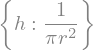

In [4]:
r, h = sympy.symbols("r, h")
Area = 2 * sympy.pi * r**2 + 2 * sympy.pi * r * h
Volume = sympy.pi * r**2 * h
h_r = sympy.solve(Volume - 1)[0]
h_r

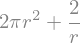

In [5]:
Area_r = Area.subs(h_r)
Area_r

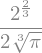

In [6]:
rsol = sympy.solve(Area_r.diff(r))[0]
rsol

In [7]:
rsol.evalf()

验证二阶导数是否为正数

In [8]:
Area_r.diff(r, 2).subs(r, rsol)

### 数值计算

In [9]:
def f(r):
    return 2 * np.pi * r**2 + 2 / r

r_min = optimize.brent(f, brack=(0.1, 4))
r_min, f(r_min)

In [10]:
optimize.minimize_scalar(f, bracket=(0.1, 4))

     fun: 5.535810445932086
    nfev: 19
     nit: 15
 success: True
       x: 0.5419260772557135

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
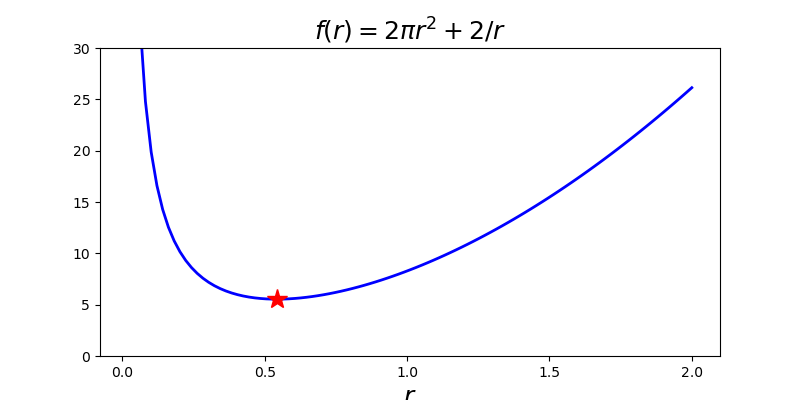

In [11]:
r = np.linspace(0, 2, 100)[1:]
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(r, f(r), lw=2, color='b')
ax.plot(r_min, f(r_min), 'r*', markersize=15)
ax.set_title(r"$f(r) = 2\pi r^2+2/r$", fontsize=18)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_ylim(0, 30)

## 多变量优化
---

在多变量的情况下，用解析法来求解非线性方程的梯度几乎不可能，黄金分割搜索法的包围法也不能直接使用。我们必须从坐标空间的某个点开始搜索，然后使用不同的策略逼近最小点。

这类方法中最基本的是考虑目标函数$f(x)$在给定点$x$处的梯度$\nabla f(x)$。通常，负的梯度总是指向函数减小最多的方向。作为寻找最小值的策略，明智的做法是沿着这个方向移动一段距离$\alpha_k$，然后在新的位置迭代这个过程。这被称为最速下降法或者[梯度下降法](https://zh.wikipedia.org/zh-cn/梯度下降法)，迭代公式是$x_{k+1} = x_k - \alpha_k \nabla f(x_k)$。该算法是很多多变量优化算法的基础。

用于多变量优化的牛顿法是最速下降法的变体，可以提高收敛速度。在多变量的情况下下，其迭代公式为$x_{k+1} = x_k - H^{-1}_f ((x_k)\nabla f(x_k)$。与最速下降法相比，梯度被替换成梯度乘以Hessian矩阵的逆。牛顿法需要同时知道函数的梯度和Hessian矩阵。

### 牛顿法

在SciPy中，函数`optimize.fmin_ncg`实现了牛顿法。该函数使用以下参数：目标函数、起始点、计算梯度的函数、计算Hessian矩阵的函数（可选）等。

考虑如下优化问题：$\min_x f(x)$, 其中目标函数$f(x)=(x_1-1)^4 + 5(x_2-1)^2 - 2x_1x_2$。为了使用牛顿法，我们将首先使用SymPy计算梯度和Hessian矩阵的符号表达式。

In [12]:
x1, x2 = sympy.symbols("x_1, x_2")
f_sym = (x1-1)**4 + 5 * (x2-1)**2 - 2*x1*x2
fprime_sym = [f_sym.diff(x_) for x_ in (x1, x2)]

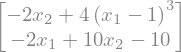

In [13]:
# Gradient
sympy.Matrix(fprime_sym)

In [14]:
fhess_sym = [[f_sym.diff(x1_, x2_) for x1_ in (x1, x2)] for x2_ in (x1, x2)]

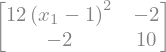

In [15]:
# Hessian
sympy.Matrix(fhess_sym)

使用`sympy.lambdify`为梯度和Hessian的表达法创建矢量化函数：

In [16]:
f_lmbda = sympy.lambdify((x1, x2), f_sym, 'numpy')
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')
fhess_lmbda = sympy.lambdify((x1, x2), fhess_sym, 'numpy')

SciPy优化函数所需要的矢量化函数希望所有坐标都在同一个数组里。为了得到SciPy兼容的函数，需要将上述函数重新封装：

In [17]:
def func_XY_X_Y(f):
    """
    Wrapper for f(X) -> f(X[0], X[1])
    """
    return lambda X: np.array(f(X[0], X[1]))

f = func_XY_X_Y(f_lmbda)
fprime = func_XY_X_Y(fprime_lmbda)
fhess = func_XY_X_Y(fhess_lmbda)

我们需要为牛顿法提供一个起点，这里使用(0, 0)作为起始点：

In [18]:
X_opt = optimize.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 8


In [19]:
X_opt

array([1.88292613, 1.37658523])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
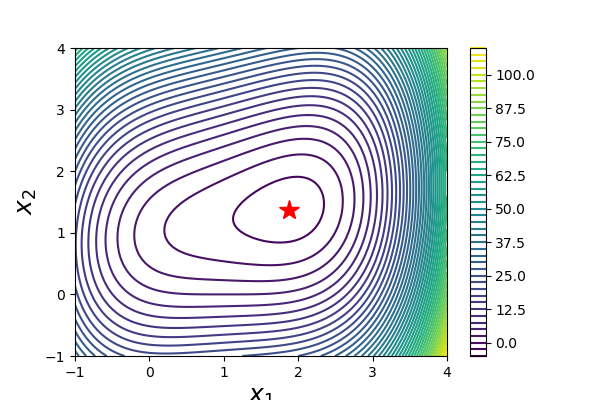

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, f_lmbda(X, Y), 50)
ax.plot(X_opt[0], X_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

### 拟牛顿法

在实际应用中，可能无法获得目标函数的梯度和Hessian矩阵。有几种方法可以计算梯度和Hessian矩阵的数值估计值。使用估计值的方法称为拟牛顿法。有两种流行方法，[BFGS法](https://zh.wikipedia.org/wiki/BFGS算法)（Broyden–Fletcher–Goldfarb–Shanno）和[共轭梯度法](https://zh.wikipedia.org/wiki/共轭梯度法)（Conjugate Gradient）。

BFGS法是一种拟牛顿法，可以逐步构建对Hessian矩阵的数值估计。共轭梯度法是最速下降法的一种变体，不使用Hessian矩阵，仅从函数计算中得到梯度的数值估计。SciPy中的函数`optimize.fmin_bfgs`和`optimize.fmin_cg`分别实现了这两种方法。

我们使用`optimize.fmin_bfgs`和`optimize.fmin_cg`重新演算上面的示例。

In [21]:
X_opt = optimize.fmin_bfgs(f, (0, 0), fprime=fprime)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 13
         Gradient evaluations: 13


In [22]:
X_opt

array([1.88292645, 1.37658596])

In [23]:
X_opt = optimize.fmin_cg(f, (0, 0), fprime=fprime)

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


In [24]:
X_opt

array([1.88292612, 1.37658523])

可以注意到，函数计算和梯度计算的次数相比牛顿法多很多。

正如前面介绍，这两种方法都不需要提供计算梯度的函数。

In [25]:
X_opt = optimize.fmin_bfgs(f, (0, 0))

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 39
         Gradient evaluations: 13


In [26]:
X_opt = optimize.fmin_cg(f, (0, 0))

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 54
         Gradient evaluations: 18


很明显，函数计算的次数更多，但是使用更加方便。通常情况下，应当**优先使用BFGS法**。

### 暴力搜索

多变量优化方法一般会收敛到局部最小值。虽然没有通用的方法解决该问题，但是可以通过在坐标网格上使用暴力搜索，从而为迭代器找到合适的起始点来部分缓解该问题。在SciPy中，函数`optimize.brute`可用于进行这样的系统性搜索。

考虑最小化函数$4 \sin x\pi + 6 \sin y\pi + (x-1)^2 + (y-1)^2$：

In [27]:
def f(X):
    x, y = X
    return (4 * np.sin(np.pi * x) + 6 * np.sin(np.pi * y)) + (x - 1)**2 + (y - 1)**2

x_start = optimize.brute(f, (slice(-3, 5, 0.5), slice(-3, 5, 0.5)), finish=None)

这里设置了关键词参数finish=None，这将阻止`optimize.brute`对找到的最优起始点进行自动优化。

In [28]:
x_start, f(x_start)

(array([1.5, 1.5]), -9.5)

这可以作为其他更复杂的迭代求解器的起始点：

In [29]:
x_opt = optimize.fmin_bfgs(f, x_start)

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 21
         Gradient evaluations: 7


In [30]:
x_opt, f(x_opt)

(array([1.47586906, 1.48365787]), -9.520229273055016)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
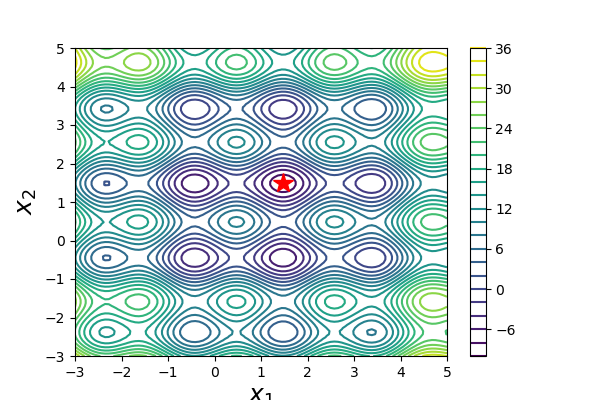

In [31]:
def func_X_Y_to_XY(f, X, Y):
    s = np.shape(X)
    return f(np.vstack([X.ravel(), Y.ravel()])).reshape(*s)

fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 25)
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

与单变量优化相同，SciPy为多变量优化求解器提供了统一的接口函数`optimize.minimize`，该函数会根据关键词参数method调用指定求解器。

In [32]:
x_opt = optimize.minimize(f, x_start, method='BFGS')

In [33]:
x_opt  # 注意返回值不是数组对象

      fun: -9.520229273055016
 hess_inv: array([[2.41596001e-02, 4.61008275e-06],
       [4.61008275e-06, 1.63490348e-02]])
      jac: array([-7.15255737e-07, -7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([1.47586906, 1.48365787])

In [34]:
x_opt.x

array([1.47586906, 1.48365787])

## 非线性最小二乘问题
---

在方程求解部分，我们已经讨论过线性最小二乘问题。

通常，最小二乘问题可看成对目标函数$g(\beta) = \sum_{i=0}^m r_i(\beta)^2$的优化问题，其中$r(\beta)$是m个观察值的残差向量，$\beta$是函数$f(x, \beta)$的位置参数向量。

如果参数$\beta$是非线性的，那么这就是一个非线性最小二乘问题。我们可以使用前面介绍的多变量优化方法，如牛顿法或拟牛顿法。目前已经有多种专门为这类特定问题开发的算法，如[Levenberg-Marquardt法](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm)，该方法的基本思想是在每次迭代中不断对问题进行线性化。

在SciPy中，函数`optimize.leastsq`提供了Levenberg-Marquardt法求解非线性最小二乘问题的求解器。

我们考虑形式为$f(x, \beta) = \beta_0 + \beta_1 \exp(-\beta_2 x^2)$的非线性模型，以及一组观测值$(x_i, y_i)$。同时，我们在真实值中添加噪声来模拟观测值。

In [35]:
beta = (0.25, 0.75, 0.5)

def f(x, beta0, beta1, beta2):
    return beta0 + beta1 * np.exp(-beta2 * x**2)

xdata = np.linspace(0, 5, 50)
y = f(xdata, *beta)  # 星号的作用是解包元组
ydata = y + 0.05 * np.random.randn(len(xdata))

定义残差函数：

In [36]:
def g(beta):
    return ydata - f(xdata, *beta)

定义参量向量的初始猜测值，使用`optimize.leastsq`函数拟合：

In [37]:
beta_start = (1, 1, 1)
beta_opt, beta_cov = optimize.leastsq(g, beta_start)

In [38]:
beta_opt, beta_cov  # The inverse of the Hessian

(array([0.26379475, 0.73098453, 0.51794562]), 1)

拟合所得结果比较接近真实值。

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
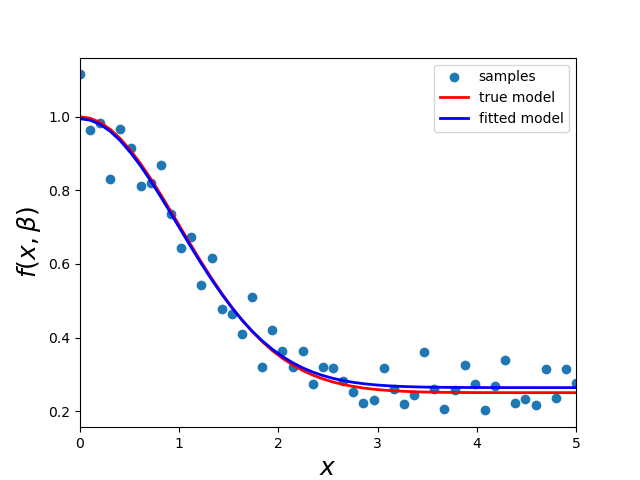

In [39]:
fig, ax = plt.subplots()

ax.scatter(xdata, ydata, label="samples")
ax.plot(xdata, y, 'r', lw=2, label="true model")
ax.plot(xdata, f(xdata, *beta_opt), 'b', lw=2, label="fitted model")
ax.set_xlim(0, 5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x, \beta)$", fontsize=18)
ax.legend()

SciPy的optimize模块还为非线性最小二乘拟合提供了一个接口函数`optimize.curve_fit`。它是对`optimize.leastsq`的封装，可以避免显式定义残差函数。

In [40]:
beta_opt, beta_cov = optimize.curve_fit(f, xdata, ydata)

In [41]:
beta_opt, beta_cov  # The estimated covariance of popt

(array([0.26379475, 0.73098453, 0.51794562]),
 array([[ 1.10527033e-04, -8.07708977e-05,  2.19040334e-04],
        [-8.07708977e-05,  4.86584294e-04,  2.43875680e-04],
        [ 2.19040334e-04,  2.43875680e-04,  1.64608789e-03]]))

## 受约束的优化问题
---

### 坐标范围

受约束问题的一种简单形式是坐标变量收某些边界条件的限制。这类问题可以使用SciPy中的L-BFGS-B法进行求解。该求解器可以通过`optimize.fmin_l_bfgs_b`函数使用，或者将`optimize.minimize`函数的method参数设置为`'L-BFGS-B'`。如果要定义坐标的边界，需要使用bound关键词参数。该参数是一个元组列表，其中包含每个约束变量的最小值和最大值。

考虑最小化函数$f(x)=(x_1-1)^2 - (x_2-1)^2$，满足约束条件$2 \leq x_1 \leq 3$和$0 \leq x_2 \leq 2$。

In [42]:
def f(X):
    x, y = X
    return (x-1)**2 + (y-1)**2

x_opt = optimize.minimize(f, [0, 0], method='BFGS').x

bnd_x1, bnd_x2 = (2, 3), (0, 2)
x_cons_opt = optimize.minimize(f, [0, 0], method='L-BFGS-B', bounds=[bnd_x1, bnd_x2]).x

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
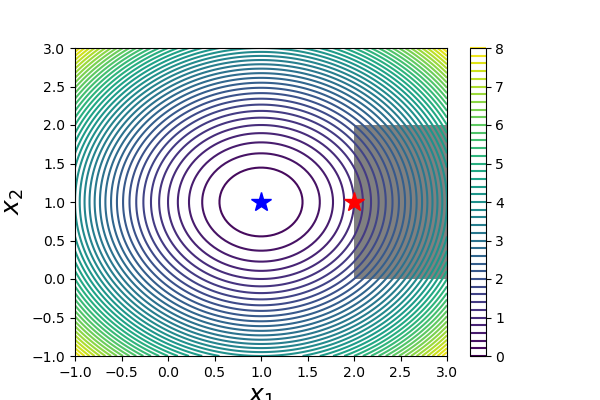

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)
bound_rect = plt.Rectangle((bnd_x1[0], bnd_x2[0]), 
                           bnd_x1[1] - bnd_x1[0], bnd_x2[1] - bnd_x2[0],
                           facecolor="grey")
ax.add_patch(bound_rect)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

### 拉格朗日乘子法

由多个变量的等式或不等式定义的约束条件更难处理。一个可行的方法是[拉格朗日乘子法](https://zh.m.wikipedia.org/zh/拉格朗日乘数)，通过引入额外的变量将受约束的优化问题转换为无约束的优化问题。

作为该方法的示例，我们考虑最大化长方体的体积（三条边的长度分别是$x_1$、$x_2$和$x_3$），限制条件是总体表面积为：$g(x)=2x_1x_2+2x_0x_2+2x_1x_0$。为了使用拉格朗日乘子法来求解该优化问题，定义拉格朗日函数$\Lambda(x) = f(x)+\lambda g(x)$，寻找 $\nabla\Lambda(x) = 0$的驻点。

In [44]:
x = x1, x2, x3, l = sympy.symbols("x_1, x_2, x_3, lambda")
f = x1 * x2 * x3
g = 2 * (x1 * x2 + x2 * x3 + x3 * x1) - 1
L = f + l * g

使用`sympy.diff`计算$\nabla \Lambda(x)$，使用`sympy.solve`求解 $\nabla\Lambda(x) = 0$。

In [45]:
grad_L = [sympy.diff(L, x_) for x_ in x]
sols = sympy.solve(grad_L)

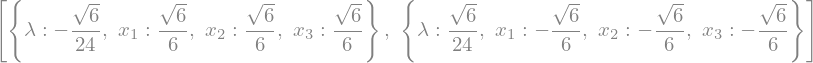

In [46]:
sols

上述计算结果给出了两个驻点。因为$x$是长方体的长度，其必须为整数。因此，最优点只有一个$x_0 = x_1 = x_2 = \frac{\sqrt{6}}{6}$。

对结果进行验证，计算约束函数和目标函数：

In [47]:
g.subs(sols[0])

In [48]:
f.subs(sols[0])

该方法进行扩展后也可以用于不等式约束。其中一个途径是被称为序列最小二乘规划（Sequential Least Square Programming）的方法。

在SciPy中，可以调用函数`optimize.minimize`，或者为`optimize.minimize`函数指明关键词参数`method='SLSQP'`。`optimize.minimize`函数的关键词参数`constraints`是一个字典列表，其中每个字典制定了一个约束条件。在字典中可以设置的键值有type（eq或ineq）、fun（约束函数）、jab（约束函数的雅可比矩阵）以及args.

我们使用SciPy的SLSQP求解器对上述示例进行数值求解。

In [49]:
def f(X):
    return -X[0] * X[1] * X[2]

def g(X):
    return 2 * (X[0]*X[1] + X[1] * X[2] + X[2] * X[0]) - 1

constraints = [dict(type='eq', fun=g)]

result = optimize.minimize(f, [0.5, 1, 1.5], method='SLSQP', constraints=constraints)

In [50]:
result

     fun: -6.804136862287297e-02
     jac: array([-0.16666925, -0.16666542, -0.16666526])
 message: 'Optimization terminated successfully'
    nfev: 77
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([0.40824188, 0.40825127, 0.40825165])

上述数值结果和使用拉格朗日乘子法的符号计算结果非常符合。

### 不等式约束

为了演示最小化非线性不等式约束下的非线性目标函数，我们前面的二次问题，这次使用不等式约束条件$g(x) = x_1 - 1.75 - (x_0 - 0.75)^4 \geq 0$。

In [51]:
def f(X):
    return (X[0] - 1)**2 + (X[1] - 1)**2

def g(X):
    return X[1] - 1.75 - (X[0] - 0.75)**4

x_opt = optimize.minimize(f, (0, 0), method='BFGS').x

In [52]:
constraints = [dict(type='ineq', fun=g)]

In [53]:
%time x_cons_opt = optimize.minimize(f, (0, 0), method='SLSQP', constraints=constraints).x

CPU times: user 5.95 ms, sys: 1.02 ms, total: 6.97 ms
Wall time: 5.7 ms


In [54]:
%time x_cons_opt = optimize.minimize(f, (0, 0), method='COBYLA', constraints=constraints).x

CPU times: user 344 µs, sys: 52 µs, total: 396 µs
Wall time: 361 µs


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
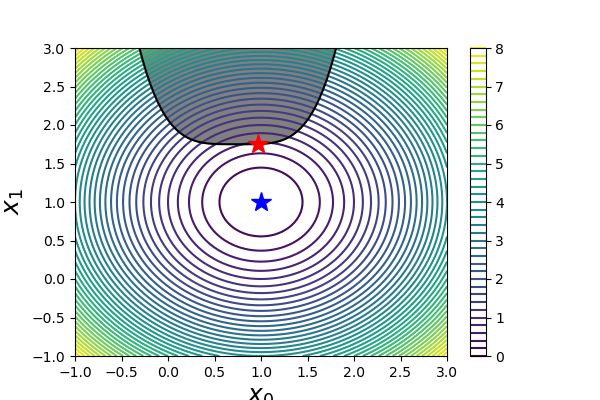

In [55]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)

ax.plot(x_, 1.75 + (x_-0.75)**4, 'k-', markersize=15)
ax.fill_between(x_, 1.75 + (x_-0.75)**4, 3, color="grey")
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)

ax.set_ylim(-1, 3)
ax.set_xlabel(r"$x_0$", fontsize=18)
ax.set_ylabel(r"$x_1$", fontsize=18)
plt.colorbar(c, ax=ax)